In [1]:
# Install flory
!pip install flory

In [2]:
import numpy as np
DTYPE = np.float64
import flory
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
from tqdm import tqdm

In [3]:
def floryHuggins(phi:DTYPE, chi:np.array):
    part_1 = np.sum(phi*np.log(phi))
    part_2 = 0

    for i in range(len(phi)):
        for j in range(i+1, len(phi)):
            part_2 += chi[i][j]*phi[i]*phi[j]

    return part_1 + part_2

### Comparing for a 2 component, 2 compartment case

Incompressibility   :   0%|          | 0/5.0 [00:00<?, ?it/s]

Field Error         :   0%|          | 0/5.0 [00:00<?, ?it/s]

Volume Error        :   0%|          | 0/5.0 [00:00<?, ?it/s]

Constraint Residue  :   0%|          | 0/5.0 [00:00<?, ?it/s]

Revive Count Left


Equlibrium phase volumes: [0.29112359 0.70887641]
Equlibrium phase concentrations:
[[0.97875201 0.02124799]
 [0.02124799 0.97875201]]


/tmp/ipykernel_451216/3487358953.py:16: RuntimeWarning: divide by zero encountered in log
  F = phi*np.log(phi) + (ones-phi)*np.log(ones-phi) + chi*phi*(ones-phi)
/tmp/ipykernel_451216/3487358953.py:16: RuntimeWarning: invalid value encountered in multiply
  F = phi*np.log(phi) + (ones-phi)*np.log(ones-phi) + chi*phi*(ones-phi)


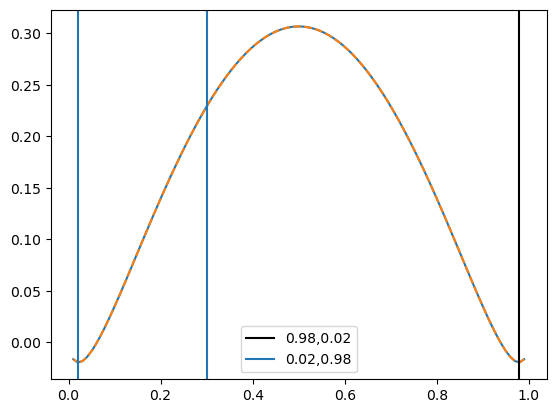

In [4]:
chis = [[0, 4], [4, 0]]
phi_means = [0.3, 0.7]

phases = flory.find_coexisting_phases(2, chis, phi_means)


print("\n" + f"Equlibrium phase volumes: {phases.volumes}")
print("Equlibrium phase concentrations:\n" + f"{phases.fractions}")


# 2d example
phi = np.linspace(0, 1, 100)
ones = np.ones(len(phi))
chi = chis[0][1]

F = phi*np.log(phi) + (ones-phi)*np.log(ones-phi) + chi*phi*(ones-phi)

plt.plot(phi, F)
plt.plot(ones-phi, F, "--")
plt.axvline(phi_means[0])
plt.axvline(phases.fractions[0, 0], label = f"{phases.fractions[0, 0]:.2f},{phases.fractions[0, 1]:.2f}", color  = "k")
plt.axvline(phases.fractions[0, 1], label = f"{phases.fractions[1, 0]:.2f},{phases.fractions[1, 1]:.2f}")
plt.legend(loc = "best")


In [5]:
chis = [[0, 4.0], [4.0, 0]]
phi_global = [0.5, 0.5]

phases = flory.find_coexisting_phases(2, chis, phi_global, progress=False)

print("\n" + f"Equlibrium phase volumes: {phases.volumes}")
print("Equlibrium phase concentrations:\n" + f"{phases.fractions}")


Equlibrium phase volumes: [0.5 0.5]
Equlibrium phase concentrations:
[[0.97875201 0.02124799]
 [0.02124799 0.97875201]]


In [6]:
step_size = DTYPE(0.01)
n_points = 1000

eta_1_perturbed = np.linspace(phases.volumes[0] - n_points*step_size, phases.volumes[0]+n_points*step_size, 2*n_points+1)
phi_11_perturbed = np.linspace(phases.fractions[0, 0] - n_points*step_size, phases.fractions[0, 0]+n_points*step_size, 2*n_points+1)

accepted_eta_1 = []
accepted_phi_11 = []
accepted_phi_12 = []
accepted_F = []

for eta_1 in tqdm(eta_1_perturbed):
    if eta_1 > 1 or eta_1 < 0:
        continue
    
    eta_2 = 1 - eta_1
    
    for phi_11 in phi_11_perturbed:
        if phi_11 > 1 or phi_11 < 0:
            continue

        phi_12 = (phi_global[0] - eta_1*phi_11)/(1-eta_1)

        if phi_12 > 0 and phi_12 < 1:
            phi_21 = 1 - phi_11 
            phi_22 = 1 - phi_12
            
            phi_in_k1 = [phi_11, phi_21]
            phi_in_k2 = [phi_12, phi_22]
            
            F = 0
            F += eta_1*floryHuggins(phi_in_k1, chis)
            F += eta_2*floryHuggins(phi_in_k2, chis)
            
            accepted_eta_1.append(eta_1)
            
            accepted_phi_11.append(phi_11)
            accepted_phi_12.append(phi_12)
            
            accepted_F.append(F)

100%|█████████████████████████████████████████████████████| 2001/2001 [00:00<00:00, 26069.46it/s]


In [7]:
df = pd.DataFrame()
df["eta_1"] = accepted_eta_1
df["phi_11"] = accepted_phi_11
df["phi_12"] = accepted_phi_12
df["F"] = accepted_F

df

,eta_1,phi_11,phi_12,F
0,0.01,0.008752,0.504962,0.303581
1,0.01,0.018752,0.504861,0.303542
2,0.01,0.028752,0.504760,0.303553
3,0.01,0.038752,0.504659,0.303592
4,0.01,0.048752,0.504558,0.303650
...,...,...,...,...
6878,0.97,0.498752,0.540352,0.306752
6879,0.97,0.508752,0.217018,0.302196
6880,0.98,0.498752,0.561151,0.306701
6881,0.98,0.508752,0.071151,0.300721


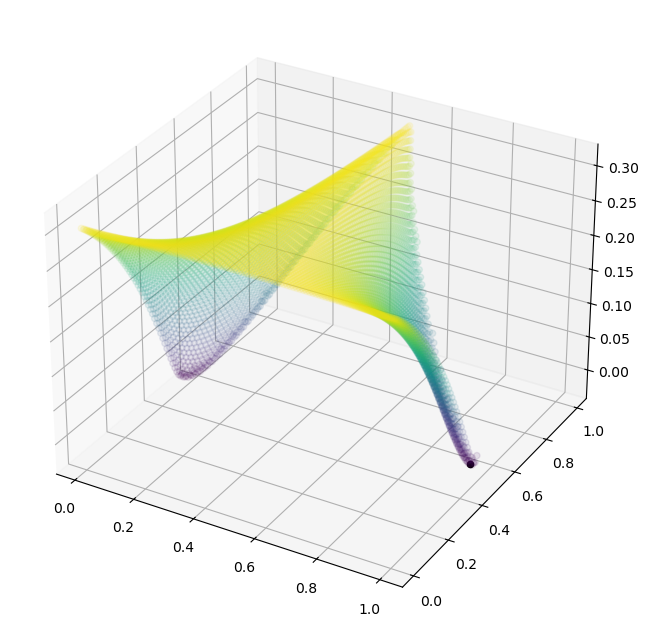

In [8]:
F = 0
for i in range(len(phases.volumes)):
    F += phases.volumes[i]*floryHuggins(phases.fractions[i, :], chis)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the data
ax.scatter(df["phi_11"], df["eta_1"], df["F"], c=df["F"], cmap="viridis", marker="o", alpha = 0.1)


ax.scatter(phases.fractions[0,0], phases.volumes[0], F, color = "k")

### 3 component case

In [9]:
# Interaction matrix
chis = np.array([[0, 3.0, 3.0], [3.0, 0.0, 3.0], [3.0, 3.0, 0.0]], dtype = DTYPE)

# Global value of phis
phi_global = np.array([0.4, 0.3, 0.3], dtype = DTYPE)

# Equilibrium 3 phase solution
phases = flory.find_coexisting_phases(3, chis, phi_global, progress=False)

print("\n" + f"Equlibrium phase volumes: {phases.volumes}")
print("Equlibrium phase concentrations:\n" + f"{phases.fractions}")


Equlibrium phase volumes: [0.42638692 0.28681103 0.28680204]
Equlibrium phase concentrations:
[[0.8109252  0.09453632 0.09453839]
 [0.09454731 0.81090661 0.09454622]
 [0.09454217 0.09453901 0.8109188 ]]


In [10]:
step_size = DTYPE(0.01)
n_points = 10

In [29]:
# perturbing the phase volumes around the phase-separated volumes
eta_1_perturbed = np.linspace(phases.volumes[0] - n_points*step_size, phases.volumes[0]+n_points*step_size, 2*n_points+1)
eta_2_perturbed = np.linspace(phases.volumes[1] - n_points*step_size, phases.volumes[1]+n_points*step_size, 2*n_points+1)

# perturbing the concentrations around the phase separated ones
# notation: phi_ij -> phi for componenent i in compartment j
phi_11_perturbed = np.linspace(phases.fractions[0, 0]-n_points*step_size, phases.fractions[0, 0]+n_points*step_size, 2*n_points+1)
phi_12_perturbed = np.linspace(phases.fractions[0, 1]-n_points*step_size, phases.fractions[0, 1]+n_points*step_size, 2*n_points+1)
phi_21_perturbed = np.linspace(phases.fractions[1, 0]-n_points*step_size, phases.fractions[1, 0]+n_points*step_size, 2*n_points+1)
phi_22_perturbed = np.linspace(phases.fractions[1, 1]-n_points*step_size, phases.fractions[1, 1]+n_points*step_size, 2*n_points+1)


accepted_eta_1_perturbed = []
accepted_eta_2_perturbed = []

accepted_phi_11_perturbed = []
accepted_phi_12_perturbed = []
accepted_phi_21_perturbed = []
accepted_phi_22_perturbed = []

accepted_Fs = []

In [30]:
ctr = 0 # Number of perturbations accepted

for eta_1 in tqdm(eta_1_perturbed):
    for eta_2 in eta_2_perturbed:
        if eta_1<0 or eta_2<0 or eta_1>1 or eta_2>1: # volume constraints
            continue

        eta_3 = 1 - eta_1 - eta_2 # Calculate the volume of the third compartment/phase
        if eta_3<0 or eta_3>1:
            continue
            
        for phi_11 in phi_11_perturbed:
            for phi_12 in phi_12_perturbed:
                if phi_11<0 or phi_11>1 or phi_12<0 or phi_12>1:
                    continue

                # Calculate the concentration of component 1 in compartment 3
                phi_13 = (phi_global[0] - eta_1*phi_11 - eta_2*phi_12)/(1-eta_1-eta_2)

                if phi_13 < 0 or phi_13 > 1:
                    continue

                for phi_21 in phi_21_perturbed:
                    for phi_22 in phi_22_perturbed:
                        if phi_21<0 or phi_21>1 or phi_22<0 or phi_22>1:
                            continue

                        # Calculate the concentration of componenent 2 in compartment 3
                        phi_23 = (phi_global[1] - eta_1*phi_21 - eta_2*phi_22)/(1-eta_1-eta_2)

                        if phi_23<0 or phi_23>1:
                            continue
                        ctr += 1


                        # Now the system is determined completely
                        phi_31 = 1 - phi_11 - phi_21
                        phi_32 = 1 - phi_12 - phi_22
                        phi_33 = 1 - phi_13 - phi_23

                        phi_in_k1 = [phi_11, phi_21, phi_31]
                        phi_in_k2 = [phi_12, phi_22, phi_32]
                        phi_in_k3 = [phi_13, phi_23, phi_33]


                        # print(eta_1*phi_13 + eta_2*phi_23 + eta_3*phi_33) # Should sum up to phi_global[2]
                        # if ctr%100000:
                        #     print(phi_in_k1)
                        #     print(phi_in_k2)
                        #     print(phi_in_k3)
                        #     print()

                        
                        # Calculate free energy
                        F = 0
                        
                        F += eta_1 * floryHuggins(phi_in_k1, chis)
                        F += eta_2 * floryHuggins(phi_in_k2, chis)
                        F += eta_3 * floryHuggins(phi_in_k3, chis)

                        accepted_Fs.append(F)
                        
                        accepted_eta_1_perturbed.append(eta_1)
                        accepted_eta_2_perturbed.append(eta_2)
                        
                        accepted_phi_11_perturbed.append(phi_11)
                        accepted_phi_12_perturbed.append(phi_12)
                        accepted_phi_21_perturbed.append(phi_21)
                        accepted_phi_22_perturbed.append(phi_22)

/tmp/ipykernel_451216/753458085.py:2: RuntimeWarning: invalid value encountered in log0<?, ?it/s]
  part_1 = np.sum(phi*np.log(phi))
100%|████████████████████████████████████████████████████████████| 21/21 [09:16<00:00, 26.48s/it]


In [31]:
ctr/21**6

0.4125612140019717

In [32]:
df = pd.DataFrame()
df["eta_1"] = accepted_eta_1_perturbed
df["eta_2"] = accepted_eta_2_perturbed
df["phi_11"] = accepted_phi_11_perturbed
df["phi_12"] = accepted_phi_12_perturbed
df["phi_21"] = accepted_phi_21_perturbed
df["phi_22"] = accepted_phi_22_perturbed
df["F"] = accepted_Fs

df

,eta_1,eta_2,phi_11,phi_12,phi_21,phi_22,F
0,0.326387,0.186811,0.710925,0.004536,0.004547,0.710907,-0.050201
1,0.326387,0.186811,0.710925,0.004536,0.004547,0.720907,-0.050891
2,0.326387,0.186811,0.710925,0.004536,0.004547,0.730907,-0.051599
3,0.326387,0.186811,0.710925,0.004536,0.004547,0.740907,-0.052322
4,0.326387,0.186811,0.710925,0.004536,0.004547,0.750907,-0.053058
...,...,...,...,...,...,...,...
35383770,0.526387,0.386811,0.750925,0.004536,0.024547,0.730907,-0.047639
35383771,0.526387,0.386811,0.750925,0.004536,0.024547,0.740907,-0.045570
35383772,0.526387,0.386811,0.750925,0.004536,0.034547,0.710907,-0.052666
35383773,0.526387,0.386811,0.750925,0.004536,0.034547,0.720907,-0.053130


In [33]:
# Minimum value from the flory package
F_flory = 0
for i in range(len(phases.volumes)):
    F_flory += phases.volumes[i]*floryHuggins(phases.fractions[i, :], chis)

# Minimum value after perturbations
F_perturb = np.min(df["F"])

print(F_flory > F_perturb)

False


In [34]:
min_F_row = df[df['F'] == df['F'].min()]
min_F_row

,eta_1,eta_2,phi_11,phi_12,phi_21,phi_22,F
26339381,0.426387,0.286811,0.810925,0.094536,0.094547,0.810907,-0.129147


### Merging compartments

In [36]:
print("\n" + f"Equlibrium phase volumes: {phases.volumes}")
print("Equlibrium phase concentrations:\n" + f"{phases.fractions}")


Equlibrium phase volumes: [0.42638692 0.28681103 0.28680204]
Equlibrium phase concentrations:
[[0.8109252  0.09453632 0.09453839]
 [0.09454731 0.81090661 0.09454622]
 [0.09454217 0.09453901 0.8109188 ]]


In [91]:
phases.fractions = np.transpose(phases.fractions)

In [92]:
phases.fractions

array([[0.8109252 , 0.09454731, 0.09454217],
       [0.09453632, 0.81090661, 0.09453901],
       [0.09453839, 0.09454622, 0.8109188 ]])

In [156]:
# Merging Compartment 1 and 3

# Calculate modified compositions of each of the components in the merged case

phi_1mod  = (phases.volumes[0]*phases.fractions[0, 0] + phases.volumes[2]*phases.fractions[0, 2])/(phases.volumes[0] + phases.volumes[2])
phi_2mod  = (phases.volumes[0]*phases.fractions[1, 0] + phases.volumes[2]*phases.fractions[1, 2])/(phases.volumes[0] + phases.volumes[2])
phi_3mod  = (phases.volumes[0]*phases.fractions[2, 0] + phases.volumes[2]*phases.fractions[2, 2])/(phases.volumes[0] + phases.volumes[2])
eta_mod = phases.volumes[0] + phases.volumes[2]

# So, now we have two phases with [phi_1mod, phi_2mod, phi_3mod] and [phases.fractions[0, 1], phases.fractions[1, 1], phases.fractions[2, 1]]
# with volumes (phases.volumes[0] + phases.volumes[2]) and phases.volumes[1]

phi_in_kmod = [phi_1mod, phi_2mod, phi_3mod]
phi_in_k2 = [phases.fractions[0, 1], phases.fractions[1, 1], phases.fractions[2, 1]]

F_mod = eta_mod*floryHuggins(phi_in_kmod, chis) + phases.volumes[1]*floryHuggins(phi_in_k2, chis)
print(F_flory > F_mod) # If false, the phase separated solution is still the globally stable state


False


In [157]:
phases.fractions[0, 0] + phases.fractions[1, 0] + phases.fractions[2, 0]

0.999999911243072

In [120]:
# Here, we can only change the relative concentrations of phis in the modified compartment
# Can't change the volumes of the individual compartments.

phi_1mod_perturbed = np.linspace(phi_1mod-n_points*step_size, phi_1mod+n_points*step_size, 2*n_points+1)
phi_2mod_perturbed = np.linspace(phi_2mod-n_points*step_size, phi_2mod+n_points*step_size, 2*n_points+1)
phi_3mod_perturbed = np.linspace(phi_3mod-n_points*step_size, phi_3mod+n_points*step_size, 2*n_points+1)

accepted_phi_1mod_perturbed = []
accepted_phi_2mod_perturbed = []
accepted_phi_3mod_perturbed = []
accepted_Fs_mod = []

In [166]:
ctr = 0
for  phi_1m in phi_1mod_perturbed:
    for phi_2m in phi_2mod_perturbed:
        for phi_3m in phi_3mod_perturbed:
            if phi_1m<0 or phi_2m<0 or phi_3m<0 or phi_1m>1 or phi_2m>1 or phi_3m>1:
                continue
                
            phi_in_kmod = [phi_1m, phi_2m, phi_3m]
            # print(np.isclose(np.sum(phi_in_kmod), 1, atol =1e-7))
            if np.isclose(np.sum(phi_in_kmod), 1, atol =1e-7):
                ctr += 1
                    
                F = 0
                F = eta_mod*floryHuggins(phi_in_kmod, chis) + phases.volumes[1]*floryHuggins(phi_in_k2, chis)
                
                accepted_phi_1mod_perturbed.append(phi_1m)
                accepted_phi_2mod_perturbed.append(phi_2m)
                accepted_phi_3mod_perturbed.append(phi_3m)
                accepted_Fs_mod.append(F)

In [167]:
ctr/21**3

0.03455350394125904

In [168]:
df = pd.DataFrame()
df["phi_1mod"] = accepted_phi_1mod_perturbed
df["phi_2mod"] = accepted_phi_1mod_perturbed
df["phi_3mod"] = accepted_phi_2mod_perturbed
df["F"] = accepted_Fs_mod

df

,phi_1mod,phi_2mod,phi_3mod,F
0,0.422839,0.422839,0.094537,-0.086635
1,0.422839,0.422839,0.104537,-0.089734
2,0.422839,0.422839,0.114537,-0.092426
3,0.422839,0.422839,0.124537,-0.094768
4,0.422839,0.422839,0.134537,-0.096807
...,...,...,...,...
11375,0.622839,0.622839,0.054537,-0.080540
11376,0.622839,0.622839,0.064537,-0.086967
11377,0.622839,0.622839,0.074537,-0.092484
11378,0.622839,0.622839,0.084537,-0.097234


In [169]:
min_F_row = df[df['F'] == df['F'].min()]
min_F_row

,phi_1mod,phi_2mod,phi_3mod,F
404,0.422839,0.422839,0.044537,-0.327239


In [170]:
min_F_row["phi_1mod"].values[0]+min_F_row["phi_2mod"].values[0]+min_F_row["phi_3mod"].values[0]


0.8902147947071378

In [177]:
sum_condition = (df['phi_1mod'] + df['phi_2mod'] + df['phi_3mod']).round(3) == 1.0
filtered_df = df[sum_condition]
filtered_df

,phi_1mod,phi_2mod,phi_3mod,F
6,0.422839,0.422839,0.154537,-0.100128
16,0.432839,0.432839,0.134537,-0.096759
27,0.442839,0.442839,0.114537,-0.092217
39,0.452839,0.452839,0.094537,-0.086132
52,0.462839,0.462839,0.074537,-0.077976
...,...,...,...,...
11087,0.442839,0.442839,0.114537,-0.092217
11099,0.452839,0.452839,0.094537,-0.086132
11112,0.462839,0.462839,0.074537,-0.077976
11126,0.472839,0.472839,0.054537,-0.066920


In [178]:
min_F_row = filtered_df[filtered_df['F'] == filtered_df['F'].min()]
min_F_row

,phi_1mod,phi_2mod,phi_3mod,F
2147,0.462839,0.462839,0.074537,-0.285305


In [179]:
phases.fractions

array([[0.8109252 , 0.09454731, 0.09454217],
       [0.09453632, 0.81090661, 0.09453901],
       [0.09453839, 0.09454622, 0.8109188 ]])

In [180]:
F_flory

-0.12914677529307247

In [21]:
F_perturb

-0.12914677529549137

In [119]:
eta_1_perturbed = np.linspace(phases.volumes[0] - n_points*step_size, phases.volumes[0]+n_points*step_size, 2*n_points+1)
eta_2_perturbed = np.linspace(phases.volumes[0] - n_points*step_size, phases.volumes[0]+n_points*step_size, 2*n_points+1)
phi_11_perturbed = np.linspace(phases.fractions[0, 0] - n_points*step_size, phases.fractions[0, 0]+n_points*step_size, 2*n_points+1)
phi_12_perturbed = np.linspace(phases.fractions[0, 1] - n_points*step_size, phases.fractions[0, 1]+n_points*step_size, 2*n_points+1)
phi_21_perturbed = np.linspace(phases.fractions[1, 0] - n_points*step_size, phases.fractions[1, 0]+n_points*step_size, 2*n_points+1)
phi_22_perturbed = np.linspace(phases.fractions[1, 1] - n_points*step_size, phases.fractions[1, 1]+n_points*step_size, 2*n_points+1)


In [120]:
len(eta_1_perturbed)**6

85766121

In [121]:
accepted_eta_1 = []
accepted_eta_2 = []
accepted_phi_11 = []
accepted_phi_12 = []
accepted_phi_21 = []
accepted_phi_22 = []
accepted_F = []

In [122]:
for eta_1 in tqdm(eta_1_perturbed):
    for eta_2 in eta_2_perturbed:
        if eta_1 < 0 or eta_1 > 1 or eta_2 < 0 or eta_2 > 1:
            continue  # Skip invalid eta values
        eta_3 = 1 - eta_1 - eta_2
        if eta_3 < 0 or eta_3 > 1:
            continue  # Skip invalid eta_3 values

        for phi_11 in phi_11_perturbed:
            for phi_12 in phi_12_perturbed:
                if phi_11 < 0 or phi_11 > 1 or phi_12 < 0 or phi_12 > 1:
                    continue  # Skip invalid phi values
                phi_13 = 1 - phi_11 - phi_12
                if phi_13 < 0 or phi_13 > 1:
                    continue  # Skip invalid phi_13 values

                for phi_21 in phi_21_perturbed:
                    for phi_22 in phi_22_perturbed:
                        if phi_21 < 0 or phi_21 > 1 or phi_22 < 0 or phi_22 > 1:
                            continue  # Skip invalid phi values
                        phi_23 = 1 - phi_21 - phi_22
                        if phi_23 < 0 or phi_23 > 1:
                            continue  # Skip invalid phi_23 values

                        # Calculate phi_13 and phi_23
                        phi_13 = (phi_global[0] - (eta_1 * phi_11 + eta_2 * phi_21)) / eta_3
                        phi_23 = (phi_global[1] - (eta_1 * phi_12 + eta_2 * phi_22)) / eta_3

                        if phi_13 < 0 or phi_13 > 1 or phi_23 < 0 or phi_23 > 1:
                            continue  # Skip invalid phi values

                        # Calculate phi_31, phi_32, and phi_33
                        phi_31 = 1 - phi_11 - phi_12
                        phi_32 = 1 - phi_21 - phi_22
                        phi_33 = 1 - phi_13 - phi_23

                        # Define phase compositions
                        phi_in_k1 = [phi_11, phi_21, phi_31]
                        phi_in_k2 = [phi_12, phi_22, phi_32]
                        phi_in_k3 = [phi_13, phi_23, phi_33]

                        # Calculate free energy
                        F = 0
                        F += eta_1 * floryHuggins(phi_in_k1, chis)
                        F += eta_2 * floryHuggins(phi_in_k2, chis)
                        F += eta_3 * floryHuggins(phi_in_k3, chis)


                        accepted_eta_1.append(eta_1)
                        accepted_eta_2.append(eta_2)

                        accepted_phi_11.append(phi_11)
                        accepted_phi_12.append(phi_12)
                        accepted_phi_21.append(phi_21)
                        accepted_phi_22.append(phi_22)
                        
                        accepted_F.append(F)

100%|████████████████████████████████████████████████████████████| 21/21 [01:41<00:00,  4.81s/it]


In [123]:
df = pd.DataFrame()
df["eta_1"] = accepted_eta_1
df["eta_2"] = accepted_eta_2
df["phi_11"] = accepted_phi_11
df["phi_12"] = accepted_phi_12
df["phi_21"] = accepted_phi_21
df["phi_22"] = accepted_phi_22
df["F"] = accepted_F

In [124]:
df

,eta_1,eta_2,phi_11,phi_12,phi_21,phi_22,F
0,0.326383,0.326383,0.710929,0.004535,0.004548,0.710908,-0.036459
1,0.326383,0.326383,0.710929,0.004535,0.004548,0.720908,-0.037206
2,0.326383,0.326383,0.710929,0.004535,0.004548,0.730908,-0.037910
3,0.326383,0.326383,0.710929,0.004535,0.004548,0.740908,-0.038560
4,0.326383,0.326383,0.710929,0.004535,0.004548,0.750908,-0.039144
...,...,...,...,...,...,...,...
3653841,0.526383,0.416383,0.730929,0.004535,0.024548,0.710908,-0.033132
3653842,0.526383,0.416383,0.730929,0.004535,0.034548,0.710908,-0.036631
3653843,0.526383,0.416383,0.740929,0.004535,0.004548,0.710908,-0.015548
3653844,0.526383,0.416383,0.740929,0.004535,0.014548,0.710908,-0.027749


In [125]:
len(df)/(len(eta_1_perturbed)**6)

0.042602439720924305

In [126]:
# Calculating the FH free energy of the phase-separated state

# f1 = floryHuggins(phases.fractions[0, :], chis)
# f2 = floryHuggins(phases.fractions[1, :], chis)
# f3 = floryHuggins(phases.fractions[2, :], chis)

F = 0
for i in range(len(phases.volumes)):
    F += phases.volumes[i]*floryHuggins(phases.fractions[i, :], chis)

F

-0.12914677525630983

In [127]:
np.min(df["F"])

-0.12603762153567682

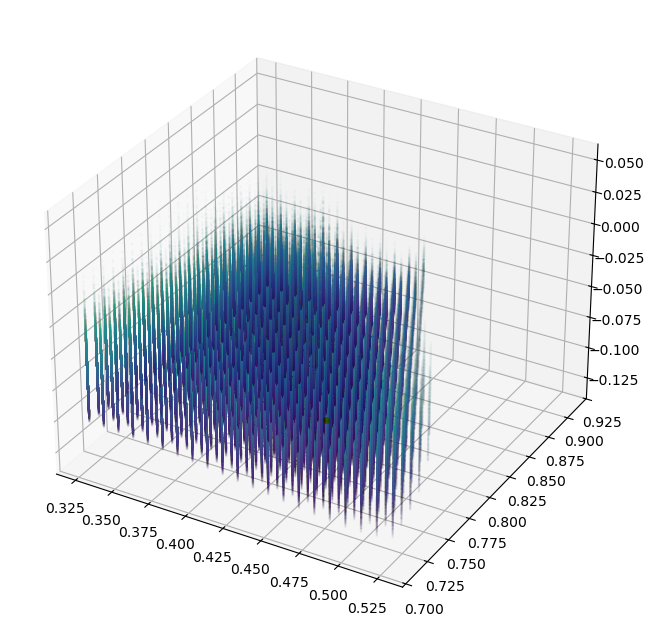

In [136]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the data
ax.scatter(df["eta_1"], df["phi_11"], df["F"], c=df["F"], cmap="viridis", marker="o", alpha = 0.008, s = 1)
ax.scatter(phases.volumes[0], phases.fractions[0,0],  F, color = "orange")


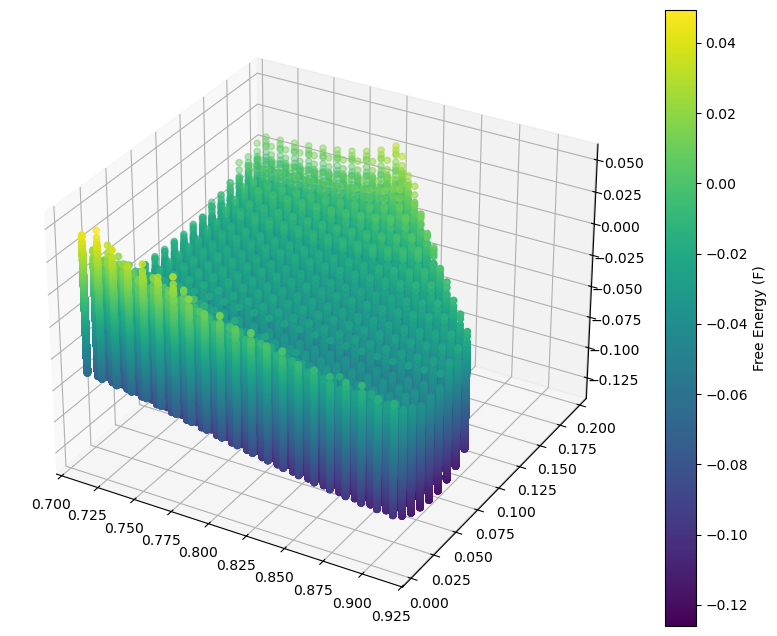

In [134]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the data
ax.scatter(df["phi_11"], df["phi_12"], df["F"], c=df["F"], cmap="viridis", marker="o", alpha = 0.008)
ax.scatter(phases.fractions[0,0], phases.fractions[0,1],  F, color = "orange")

cbar = plt.colorbar(ax.scatter(df["phi_11"], df["phi_12"], df["F"], c=df["F"], cmap="viridis"))
cbar.set_label("Free Energy (F)")

In [138]:
type(df["F"].values[0])

numpy.float64